# CS 189 Homework 4 T-SNE
**Note:** before starting this notebook, please save a copy of it to your own google drive, or your changes will not persist.

In this problem, you will explore one way in which an ML engineer might try to interpret what the neural network they have just trained is doing. It turns out that t-SNE can come in handy here not just as a data visualization tool, but also as a *feature* visualization tool. Neural nets are, after all, trying to learn good features of the data for prediction.

You will use scikit-learn's TSNE functionality for this problem, so it would be a good idea to look at that documentation. Your deliverables will be your code in this notebook as well as all plots that you produce here.



In [5]:
# Imports for pytorch
import numpy as np
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from sklearn.manifold import TSNE
import matplotlib
from matplotlib import pyplot as plt
import tqdm.notebook as tqdm

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Place the `cifar10_classifier_large.pth` file provided in the root of the My Drive section of your Google Drive. If successfully done, the below `ls` command should work.

In [20]:
!ls /content/gdrive/MyDrive/cifar10_classifier_large.pth

ls: cannot access '/content/gdrive/MyDrive/cifar10_classifier_large.pth': No such file or directory


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)

transform = torchvision.transforms.Compose(
          [torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

training_data = torchvision.datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transform,
)

test_data = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform)

batch_size = 4
trainloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Using device cuda
Files already downloaded and verified
Files already downloaded and verified


Feel free to visualize the data to get a sense of what the dataset looks like (note that the images have been normalized):

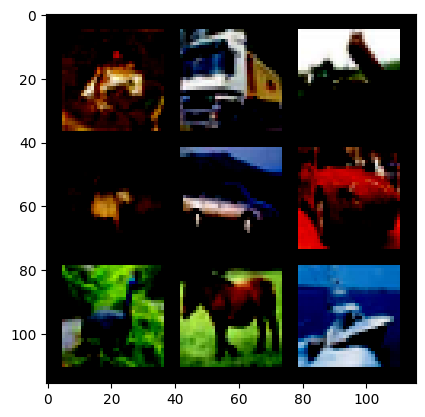

In [10]:
images = [training_data[i][0] for i in range(9)]
plt.imshow(torchvision.utils.make_grid(torch.stack(images), nrow=3, padding=5).numpy().transpose((1, 2, 0)))

Part (a): Take the first 1000 images in the training dataset and perform t-SNE on the flattened images. Plot the t-SNE embeddings and color-code them by the class of each data point.

Flattening images:   0%|          | 0/12500 [00:00<?, ?it/s]

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.006s...
[t-SNE] Computed neighbors for 5000 samples in 3.651s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.024118
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.269203
[t-SNE] KL divergence after 1000 iterations: 2.553972


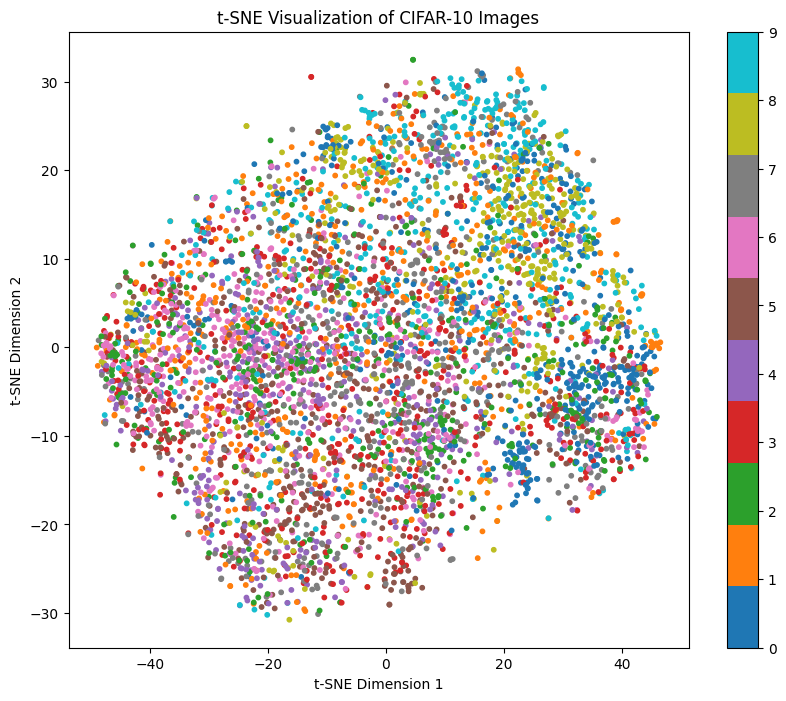

In [11]:
### Part (a) ###
### YOUR CODE HERE ###
# Flattening the CIFAR-10 images and preparing the labels
def get_flattened_images_and_labels(data_loader):
    flattened_images = []
    labels = []
    for images, targets in tqdm.tqdm(data_loader, total=len(data_loader), desc="Flattening images"):
        # Move images to the correct device (GPU or CPU)
        images = images.to(device)

        # Flatten the images: (batch_size, 3, 32, 32) -> (batch_size, 3072)
        images = images.view(images.size(0), -1)

        # Append images and their corresponding labels
        flattened_images.append(images.cpu().numpy())
        labels.append(targets.cpu().numpy())

    # Convert the lists to numpy arrays
    flattened_images = np.concatenate(flattened_images, axis=0)
    labels = np.concatenate(labels, axis=0)

    return flattened_images, labels

# Get the flattened images and labels from the training set
flattened_images, labels = get_flattened_images_and_labels(trainloader)

# Normalize the flattened images between 0 and 1
flattened_images = flattened_images.astype('float32') / 255.0

# Applying t-SNE to reduce the dimensionality to 2D for visualization
tsne = TSNE(n_components=2, random_state=42, verbose=1)
tsne_results = tsne.fit_transform(flattened_images[:5000])  # Limiting to 5000 images for quicker computation

# Plot the t-SNE results and color-code by class labels
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels[:5000], cmap='tab10', s=10)
plt.colorbar(scatter, ticks=range(10))
plt.title('t-SNE Visualization of CIFAR-10 Images')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


Part (b): Find the test accuracy of the neural network provided.



In [13]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 128, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 128, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(128, 256, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 256, 3, 1, 1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(2)
        self.linear1 = nn.Linear(256 * 8 * 8, 256)
        self.bn_l1 = nn.BatchNorm1d(256)
        self.linear2 = nn.Linear(256, 10)

    def forward(self, x):
        out = self.bn1(F.relu(self.conv1(x)))
        out = self.bn2(F.relu(self.conv2(out)))
        out = self.pool1(out)
        out = self.bn3(F.relu(self.conv3(out)))
        out = self.bn4(F.relu(self.conv4(out)))
        out = self.pool2(out)
        out = torch.flatten(out, start_dim=1)
        out = self.bn_l1(F.relu(self.linear1(out)))
        out = self.linear2(out)
        return out

# Loading model
net = Net().to(device)
model_save_name = 'cifar10_classifier_large.pth'
path = F"/content/gdrive/My Drive/{model_save_name}" # Change path if necessary!
net.load_state_dict(torch.load(path))
net.eval()

<ipython-input-13-c52f71f6a4fd>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(path))


FileNotFoundError: [Errno 2] No such file or directory: '/content/gdrive/My Drive/cifar10_classifier_large.pth'

In [14]:
### Part (b) ###
### YOUR CODE HERE ###

# Define function to calculate accuracy on test data
def calculate_accuracy(model, test_loader, device):
    correct = 0
    total = 0
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for testing
        for images, labels in tqdm.tqdm(test_loader, total=len(test_loader), desc="Evaluating accuracy"):
            images, labels = images.to(device), labels.to(device)  # Move data to the device (GPU/CPU)

            # Get model predictions
            outputs = model(images)

            # Get the predicted class by taking the index with the maximum score
            _, predicted = torch.max(outputs, 1)

            # Update the correct and total counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate and return the accuracy
    accuracy = 100 * correct / total
    return accuracy

# Calculate accuracy of the loaded model on the test data
test_accuracy = calculate_accuracy(net, testloader, device)
print(f"Accuracy of the network on the CIFAR-10 test images: {test_accuracy:.2f}%")


Evaluating accuracy:   0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy of the network on the CIFAR-10 test images: 9.98%


Part (c): For the following parts, we will make use of *hook* functions to save the outputs of particular layers of the model during a forward pass. We have provided a function below describing its usage. Use the function to obtain the set of outputs from net.conv3 for the first 1000 images of the training dataset as inputs. Then, run t-SNE on those outputs. Plot the t-SNE embeddings and color-code them by the class of each data point.

For reference, the neural network layers are: \\
net.conv1 \\
net.conv2 \\
net.conv3 \\
net.conv4 \\
net.linear1 \\
net.linear2 \\

In [15]:
class SaveFeatures():
     features=None
     def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
     def hook_fn(self, module, input, output): self.features = ((output.cpu()).data).numpy()
     def remove(self): self.hook.remove()

In [16]:
# Example: get_features_from_layer(net.conv1)
def get_features_from_layer(layer):
  activated_features = SaveFeatures(layer)
  return activated_features

Extracting features:   0%|          | 0/196 [00:00<?, ?it/s]

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.001s...
[t-SNE] Computed neighbors for 5000 samples in 0.293s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130560
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.789307
[t-SNE] KL divergence after 1000 iterations: 2.452013


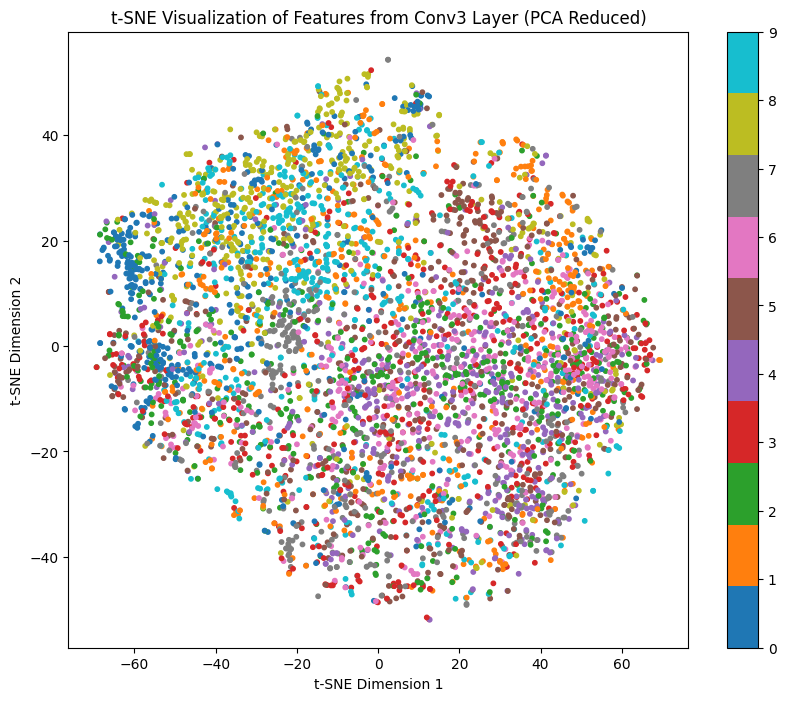

In [19]:
### Part (c) ###
### YOUR CODE HERE ###
## Hint: Call get_features_from_layer() and use the 'features' attribute of the SaveFeatures class

# Increase the batch size to process data in larger chunks
batch_size = 256  # Increased batch size for faster processing
trainloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=2)

# Function to extract features from a specific layer
def extract_features_subset(model, data_loader, device, target_layer, max_samples=5000):
    # Hook to save the features from the target layer
    features_saver = SaveFeatures(target_layer)

    features = []
    labels = []
    total_samples = 0

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No gradient needed for inference
        for images, targets in tqdm.tqdm(data_loader, total=len(data_loader), desc="Extracting features"):
            images, targets = images.to(device), targets.to(device)

            # Forward pass through the network
            _ = model(images)

            # Collect the extracted features and labels
            features.append(features_saver.features)
            labels.append(targets.cpu().numpy())

            total_samples += images.size(0)
            if total_samples >= max_samples:
                break  # Stop after collecting the desired number of samples

    # Remove the hook after extraction is complete
    features_saver.remove()

    # Concatenate features and labels (truncate if necessary)
    features = np.concatenate(features, axis=0)[:max_samples]
    labels = np.concatenate(labels, axis=0)[:max_samples]

    return features, labels

# Extract features from the third convolutional layer (conv3) for a subset of the data
conv3_layer = net.conv3
features, labels = extract_features_subset(net, trainloader, device, conv3_layer, max_samples=5000)

# Flatten the features from conv3 (if necessary, depends on layer output dimensions)
features = features.reshape(features.shape[0], -1)

# Normalize the features for better t-SNE performance
features = features.astype('float32') / np.linalg.norm(features, axis=1, keepdims=True)

# Apply PCA to reduce dimensionality before t-SNE for faster computation
pca = PCA(n_components=50)
features_pca = pca.fit_transform(features)

# Apply t-SNE to the PCA-reduced features
tsne = TSNE(n_components=2, random_state=42, verbose=1)
tsne_results = tsne.fit_transform(features_pca)

# Plot the t-SNE results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='tab10', s=10)
plt.colorbar(scatter, ticks=range(10))
plt.title('t-SNE Visualization of Features from Conv3 Layer (PCA Reduced)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


Part (d): Do the same as part (c) except for the first and second linear layers of the network.

Extracting features:   0%|          | 0/196 [00:00<?, ?it/s]

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.001s...
[t-SNE] Computed neighbors for 5000 samples in 0.381s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.087912
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.751892
[t-SNE] KL divergence after 1000 iterations: 2.432738


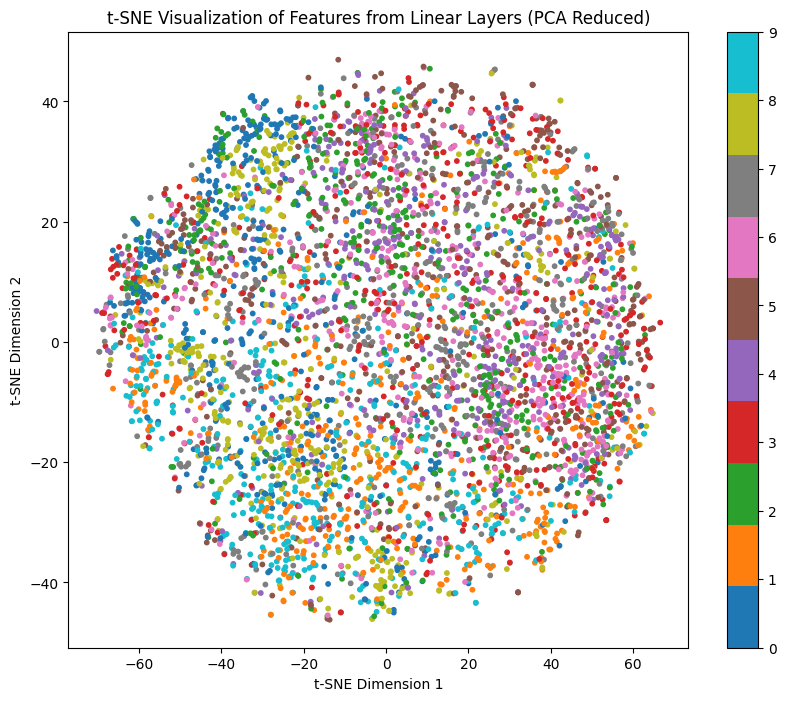

In [22]:
### Part (d) ###
### YOUR CODE HERE ###

# Extract features from both linear1 and linear2 layers
# Hook class to save the output of the layer


# Function to extract features from a specific layer
def extract_features_from_layers(model, data_loader, device, target_layers, max_samples=5000):
    # Register the hooks on the desired layers
    feature_savers = [SaveFeatures(layer) for layer in target_layers]

    features = []
    labels = []
    total_samples = 0

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No gradient needed for inference
        for images, targets in tqdm.tqdm(data_loader, total=len(data_loader), desc="Extracting features"):
            images, targets = images.to(device), targets.to(device)

            # Forward pass through the network
            _ = model(images)

            # Collect the extracted features and labels
            layer_features = [saver.features for saver in feature_savers]
            features.append(np.concatenate(layer_features, axis=1))  # Concatenate the features from both layers
            labels.append(targets.cpu().numpy())

            total_samples += images.size(0)
            if total_samples >= max_samples:
                break  # Stop after collecting the desired number of samples

    # Remove the hooks after extraction is complete
    for saver in feature_savers:
        saver.remove()

    # Concatenate features and labels (truncate if necessary)
    features = np.concatenate(features, axis=0)[:max_samples]
    labels = np.concatenate(labels, axis=0)[:max_samples]

    return features, labels

# Extract features from the first and second linear layers (linear1 and linear2)
target_layers = [net.linear1, net.linear2]
features, labels = extract_features_from_layers(net, trainloader, device, target_layers, max_samples=5000)

# Flatten the features from the layers (if necessary)
features = features.reshape(features.shape[0], -1)

# Normalize the features for better t-SNE performance
features = features.astype('float32') / np.linalg.norm(features, axis=1, keepdims=True)

# Apply PCA to reduce dimensionality before t-SNE for faster computation
pca = PCA(n_components=50)
features_pca = pca.fit_transform(features)

# Apply t-SNE to the PCA-reduced features
tsne = TSNE(n_components=2, random_state=42, verbose=1)
tsne_results = tsne.fit_transform(features_pca)

# Plot the t-SNE results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='tab10', s=10)
plt.colorbar(scatter, ticks=range(10))
plt.title('t-SNE Visualization of Features from Linear Layers (PCA Reduced)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


Congrats! You made it to the end.